# Objective

Test functions for relations with entities that have coordinates.

In [1]:
import func_lib
import geopandas as gpd
import numpy as np
import pandas as pd
import shapefile as shp
from shapely.geometry import Point

In [125]:
import sys
!{sys.executable} -m pip install SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
import datetime
import func_lib

endpoint_url = "https://query.wikidata.org/sparql"
item = "item"

class Relation:
    """
    The class returned when createRelation is called.
    It contains string field with query.
    We call Relation.query when we need to do the query.
    """

    def __init__(self, entity_id: str, property_id: str, isSubject: bool, rowVerbose: bool,
                 colVerbose: bool, time_property: str, time: str, name: str, label: bool, limit=10000, subclass=False):
        self.entity_id = entity_id
        self.query_str = ""
        self.dic = {}
        self.result_dic = {"Entity ID": []}
        self.df = pd.DataFrame()
        self.count = 0
        self.time_property = time_property
        self.time = time
        self.limit = limit
        self.subclass = subclass
        self.focus = "Entity ID"
        if property_id:
            self.extend(property_id, isSubject, name, rowVerbose, colVerbose, limit, time_property, time, label, subclass)

    def generate_html(self, name: str):
        html = (self.df).to_html()
        text_file = open(name, "w", encoding='utf-8')
        text_file.write(html)
        text_file.close()

    def query(self, require=None):
        if self.query_str == "":
            self.result_dic = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
            return self.result_dic
        results = get_results(endpoint_url, self.query_str)
        result_dict = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
        for i in range(1, self.count + 1):
            result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id']] = []
            if self.dic[i]["colVerbose"]:
                result_dict[self.dic[i]["name"] + '_rank_' + self.dic[i]['property_id'] + '_rank'] = []
                for key, value in self.dic[i]["property_name_dic"].items():
                    result_dict[
                        self.dic[i]["name"] + "_" + value + '_' + self.dic[i]['property_id'] + '_' + str(key)] = []
                for key, value in self.dic[i]["ref_dic"].items():
                    result_dict[self.dic[i]["name"] + "_ref_" + self.dic[i]['property_id'] + '_' + str(key)] = []

            if self.dic[i]["label"]:
                result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id'] + 'Label'] = []

        for result in results['results']['bindings']:
            for key, value in result_dict.items():
                if key in result.keys():
                    result_dict[key].append(result[key]['value'])
                else:
                    result_dict[key].append('NA')
        result_dict["Entity ID"] = ['http://www.wikidata.org/entity/' + str(self.entity_id)] * len(
            result_dict[self.dic[self.count]["name"] + '_' + self.dic[self.count]["property_id"]])
        self.result_dic = result_dict
        self.df = pd.DataFrame.from_dict(self.result_dic)
        for i in range(1, self.count + 1):
            if self.dic[i]["colVerbose"] and not self.dic[i]["rowVerbose"]:
                col = self.dic[i]['name'] + '_rank_' + self.dic[i]['property_id'] + '_rank'
                if any(self.df[col] == 'http://wikiba.se/ontology#PreferredRank'):
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#PreferredRank']
                else:
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#NormalRank']
#         if require is not None:
#             for r in require:
#                 self.df = self.df.loc[self.df[r] != 'NA']
        self.df = pd.DataFrame(data=self.df)
#         if self.df.shape[0] >= 10000:
#             print("Warning: Your query leads to too many results. Only 10,000 returned.")
        return self.df

    def extend(self, property_id: str, isSubject: bool, name: str, rowVerbose=False, colVerbose=False, limit=None,
               time_property=None, time=None, search=None, label=False, subclass=False):
        self.count += 1
        self.dic[self.count] = {}
        self.dic[self.count]["name"] = name
        self.dic[self.count]["focus"] = self.focus
        self.dic[self.count]["property_id"] = property_id
        self.dic[self.count]["isSubject"] = isSubject
        self.dic[self.count]["limit"] = limit
        self.dic[self.count]["rowVerbose"] = rowVerbose
        self.dic[self.count]["colVerbose"] = colVerbose
        self.dic[self.count]['time_property'] = time_property
        self.dic[self.count]['time'] = time
        self.dic[self.count]['search'] = search
        self.dic[self.count]['label'] = label
        self.dic[self.count]['subclass'] = subclass
        # subclass is specific to P31, when subclass is true, we get intance of all subclasses of the entity
        if rowVerbose or colVerbose:
            self.dic[self.count]["property_name_dic"], self.dic[self.count][
                "ref_dic"] = self.search_property_for_verbose()
        if time_property and time:
            self.time_property = time_property
            self.time = time
        if limit:
            self.limit = limit
        self.query_str = self.define_query_relation()

    def changeFocus(self, name="Entity ID"):
        self.focus = name
        
    def extendWithFunction(self, objcolumn, func, name):
        if type(func) == str:
            if func.startswith('F'):
                try:
                    func_id = int(func[1:])
                    if func_id >= func_lib.func_num():
                        print("Not available.")
                    else:
                        if isinstance(objcolumn, list):
                            self.df[name] = self.df[objcolumn].apply(lambda x: func_lib.func_list[func_id](*x), axis=1)
                        else:
                            self.df[name] = self.df[objcolumn].apply(func_lib.func_list[func_id])
                except:
                    raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
            else:
                raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
        else:
            if isinstance(objcolumn, list):
                self.df[name] = self.df[objcolumn].apply(lambda x: func(*x), axis=1)
            else:
                self.df[name] = self.df[objcolumn].apply(func)

    def define_query_relation(self):
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.count < 1:
            return None
        focusChanges = 0
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                if self.dic[i]["search"] is None and not self.dic[i]["isSubject"]:
                        rdf_triple += """OPTIONAL {"""
                if self.dic[i]["focus"] == "Entity ID":
#                     if self.dic[i]["search"] is None:
#                         rdf_triple += """OPTIONAL {"""
                    rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    rdf_triple += """?""" + self.dic[i]["focus"] + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                for key, value in self.dic[i]["property_name_dic"].items():
                    rdf_triple += """OPTIONAL { """ + """?statement_""" + str(i) + """ pq:""" + str(key) \
                                  + """ ?""" + self.dic[i]['name'] + """_""" + value + """_""" + self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                for key, value in self.dic[i]["ref_dic"].items():
                    rdf_triple += """OPTIONAL { ?statement_""" + str(
                        i) + """ prov:wasDerivedFrom ?refnode_""" + str(
                        i) + """. ?refnode_""" + str(i) \
                                  + """ pr:""" + str(key) + """ ?""" + self.dic[i]['name'] + """_ref_""" + \
                                  self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                rdf_triple += """OPTIONAL { ?statement_""" + str(i) + """ wikibase:rank ?""" + self.dic[i][
                    'name'] + """_rank_""" + self.dic[i]['property_id'] + """_rank. } """
            # none-verbose version
            else:
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        if not self.dic[i]['subclass']:
                            rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i][
                                              "property_id"] + """ wd:""" + self.entity_id + """. """
                        else:
                            if self.dic[i]['property_id'] == "P31":
                                rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                    'property_id'] + """ wdt:""" + self.dic[i][
                                                  "property_id"] + """ ?subclasses. """
                                rdf_triple += """?subclasses wdt:P279+ wd:""" + self.entity_id + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    if self.dic[i]["isSubject"]:
                        if not self.dic[i]['subclass']:
                            rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + self.dic[i][
                                              'focus'] + """. """
                        else:
                            if self.dic[i]['property_id'] == "P31":
                                rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i]["property_id"] + """ ?subclasses. """
                                rdf_triple += """?subclasses wdt:P279+ ?""" + self.dic[i]['focus'] + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """?""" + self.dic[i]['focus'] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                          'property_id'] + """. """
            if not self.dic[i]["isSubject"]:
                if i < self.count and self.dic[i]["focus"] != self.dic[i + 1]["focus"] and self.dic[i]["search"] is None:
                    focusChanges += 1
                elif self.dic[i]["search"] is None:
                    rdf_triple += """} """
                
        for i in range(focusChanges):
            rdf_triple += """} """
        for i in range(1, self.count + 1):
            if self.dic[i]['search'] is not None and self.dic[i]["search"] != '!NA':
                if isinstance(self.dic[i]['search'], tuple):
                    if isinstance(self.dic[i]['search'][0], str):
                        rdf_triple += """FILTER (YEAR(?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                            'property_id'] + """) >= """ + \
                                      self.dic[i]['search'][0] + """ && YEAR(?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """) <= """ + self.dic[i]['search'][
                                          1] + """) """
                    else:
                        rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i]['property_id'] + \
                                      """ >= """ + str(self.dic[i]['search'][0]) + """ && ?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """ <= """ + str(
                            self.dic[i]['search'][1]) + """) """
                else:
                    rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                        'property_id'] + """ = """ + \
                                  """wd:""" + self.dic[i]['search'] + """) """
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                          ?pubdateStatement ps:""" + self.time_property + """ ?date	
                          FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT"""
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
                for key, value in self.dic[i]["property_name_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_""" + value + """_""" + self.dic[i][
                        'property_id'] + """_""" + str(key)
                for key, value in self.dic[i]["ref_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_ref_""" + self.dic[i]['property_id'] + """_""" + str(
                        key)
                query += """ ?""" + self.dic[i]["name"] + """_rank_""" + self.dic[i]['property_id'] + """_rank"""
            else:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
        query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
        return query

    def search_property_for_verbose(self):
        property_to_name = {}
        ref_to_name = {}
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            for i in range(1, self.count):
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ wd:""" + self.entity_id + """ ."""
                    else:
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """ ."""
                else:
                    last = self.dic[i]["focus"].rfind('_')
                    focus = self.dic[i]["focus"][:last]
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + focus + """ ."""
                    else:
                        rdf_triple += """?""" + focus + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """ ."""
            if self.dic[self.count]["focus"] == "Entity ID":
                rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
            else:
                last = self.dic[self.count]["focus"].rfind('_')
                focus = self.dic[self.count]["focus"][:last]
                rdf_triple += """?""" + focus + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                                  ?pubdateStatement ps:""" + self.time_property + """ ?date	
                                  FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT """
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            query += """?item""" + """ ?qual""" + """ ?qualLabel""" + """ ?obj """ + """?pr ?prLabel"""
            query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
            query_result = get_results(endpoint_url, query)
            for result in query_result['results']['bindings']:
                if 'qual' in result:
                    property_to_name[result['qual']['value'].split('/')[-1]] = result['qualLabel']['value'].replace(' ',
                                                                                                                    '_')
                if 'pr' in result:
                    ref_to_name[result['pr']['value'].split('/')[-1]] = result['prLabel']['value'].replace(' ', '_')
        else:
            query += """?""" + self.dic[self.count]["name"] + """ """
        return property_to_name, ref_to_name

    def __str__(self):
        return str(self.df)

    def __getattr__(self, col_name):
        if col_name in self.df.columns:
            return self.df[col_name]
        else:
            print(col_name + " has not been found.")
            return None


def createRelation(entity_id: str, property_id=None, isSubject=None, rowVerbose=None, colVerbose=None,
                   time_property=None, time=None, name=None, label=False, limit=None, subclass=False):
    if property_id and not name:
        print("Please specify the name of the first column")
        return None
    return Relation(entity_id, property_id, isSubject, rowVerbose, colVerbose, time_property, time, name, label, limit, subclass)

def get_Firstname(name: str):
    return name.split(' ')[0]

def get_Lastname(name: str):
    return name.split(' ')[-1]

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def get_name(id: str):
    query = """PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 	
                PREFIX wd: <http://www.wikidata.org/entity/> 	
                select  *	
                where {	
                wd:""" + id + """ rdfs:label ?label .	
                FILTER (langMatches( lang(?label), "EN" ) )	
                } 	
                LIMIT 1"""
    results = get_results(endpoint_url, query)
    result = ''
    for res in results["results"]["bindings"]:
        result = res['label']['value']
    return result

# Functions for coordinates
- parse_lon_lat()
- lon_lat_to_fips()
- fips_to_county_name()
- lon_lat_to_urban_area()

In [45]:
gov_building_subclass = 'courthouse'
qnum = 'Q1137809'
r = createRelation(qnum, label=True)
r.extend('P31', True, 'gov_building_subclass', label=True) # extend via property P31 = is instance of

r.changeFocus('gov_building_subclass_P31')
r.extend('P17', False, 'Country',label=True, search="Q30") # extend via property P17 = is in country
r.extend('P131', False, 'State', label=True)
r.extend('P625', False, 'Lon_Lat')
r.query()

df = r.df
df['building_type_label'] = [gov_building_subclass for _ in range(len(df))]

print('There are %s instances of %s in the US.' % (str(len(df)), gov_building_subclass))


There are 412 instances of courthouse in the US.


Confirm that missing lon/lat values are represented as 'NA' in the dataframe from the relation:

In [44]:
df[df.Lon_Lat_P625.str[0] != 'P'].head()

,Entity ID,gov_building_subclass_P31,gov_building_subclass_P31Label,Country_P17,Country_P17Label,State_P131,State_P131Label,Lon_Lat_P625,building_type_label
106,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7889685,United States Courthouse,http://www.wikidata.org/entity/Q30,United States of America,NA,NA,NA,courthouse
107,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891098,United States Post Office and Courthouse,http://www.wikidata.org/entity/Q30,United States of America,NA,NA,NA,courthouse
166,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q8010528,William H. Natcher Federal Building and United...,http://www.wikidata.org/entity/Q30,United States of America,NA,NA,NA,courthouse
201,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q8034172,Worcester County District Courthouses,http://www.wikidata.org/entity/Q30,United States of America,NA,NA,NA,courthouse
234,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q5549647,"Gerald W. Heaney Federal Building, United Stat...",http://www.wikidata.org/entity/Q30,United States of America,NA,NA,NA,courthouse


In [47]:
'''
Input: string containing longitude, latitude, and other extraneous characters
Output: (float longitude, float latitude) tuple
'''
def parse_lon_lat(lon_lat):
    if lon_lat == 'NA':
        return 'NA'
    entities = lon_lat[6:-1].split(' ')
    lon = float(entities[0])
    lat = float(entities[1])
    return(lon, lat)

r.extendWithFunction('Lon_Lat_P625', parse_lon_lat, 'lon_lat_parsed')

In [49]:
r.df.head()

,Entity ID,gov_building_subclass_P31,gov_building_subclass_P31Label,Country_P17,Country_P17Label,State_P131,State_P131Label,Lon_Lat_P625,building_type_label,lon_lat_parsed
0,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7624327,Strom Thurmond Federal Building and United Sta...,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q38453,Columbia,Point(-80.9384 34.0163),courthouse,"(-80.9384, 34.0163)"
1,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891079,United States Post Office and Court House,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q49241,Lexington,Point(-84.492222 38.046944),courthouse,"(-84.492222, 38.046944)"
2,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7103257,Orleans County Courthouse Historic District,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1384,New York,Point(-78.193333 43.245833),courthouse,"(-78.193333, 43.245833)"
3,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891101,United States Post Office and Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q829,Utah,Point(-111.973056 41.223056),courthouse,"(-111.973056, 41.223056)"
4,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7679018,Talbot County District Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1391,Maryland,Point(-76.0792 38.7742),courthouse,"(-76.0792, 38.7742)"


### Lon/lat to FIPS data

From the Census Bureau's shapefiles:
https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [119]:
path_shp = './cb_2018_us_county_20m/cb_2018_us_county_20m.shp'
data = gpd.read_file(path_shp)
print(len(data), 'counties')
data.head()

3220 counties


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.90200 34.83527, -78.79960 34.850..."
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49737 35.20210, -80.29542 35.502..."
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338428,6617028,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,48,459,01384015,0500000US48459,48459,Upshur,06,1509910100,24878888,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."


In [71]:
'''
Input: (float longitude, float latitude) tuple
Output: 5-character string FIPS code
'''
def lon_lat_to_fips(lon_lat):
    if lon_lat == 'NA':
        return 'NA'
    path_shp = './cb_2018_us_county_20m/cb_2018_us_county_20m.shp'
    data = gpd.read_file(path_shp)
    
    lon, lat = lon_lat
    point = Point(lon, lat)
    
    for ind in range(len(data)):
        polygon = data.geometry[ind]
        if point.within(polygon):
            return data.GEOID[ind]
r.extendWithFunction('lon_lat_parsed', lon_lat_to_fips, 'fips')

In [73]:
r.df.head()

,Entity ID,gov_building_subclass_P31,gov_building_subclass_P31Label,Country_P17,Country_P17Label,State_P131,State_P131Label,Lon_Lat_P625,building_type_label,lon_lat_parsed,fips
0,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7624327,Strom Thurmond Federal Building and United Sta...,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q38453,Columbia,Point(-80.9384 34.0163),courthouse,"(-80.9384, 34.0163)",45079
1,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891079,United States Post Office and Court House,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q49241,Lexington,Point(-84.492222 38.046944),courthouse,"(-84.492222, 38.046944)",21067
2,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7103257,Orleans County Courthouse Historic District,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1384,New York,Point(-78.193333 43.245833),courthouse,"(-78.193333, 43.245833)",36073
3,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891101,United States Post Office and Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q829,Utah,Point(-111.973056 41.223056),courthouse,"(-111.973056, 41.223056)",49057
4,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7679018,Talbot County District Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1391,Maryland,Point(-76.0792 38.7742),courthouse,"(-76.0792, 38.7742)",24041


In [110]:
'''
Input: 5-character string FIPS code
Output: string county name
'''
def fips_to_county(fips):
    if fips=='NA':
        return 'NA'
    if fips==None:
        return 'NA'
    path_shp = './cb_2018_us_county_20m/cb_2018_us_county_20m.shp'
    data = gpd.read_file(path_shp)
    try:
        return data[data.GEOID==fips].NAME.values[0]
    except:
        print(fips)
        print(type(fips))

r.extendWithFunction('fips', fips_to_county, 'county_name')

In [111]:
r.df.head()

,Entity ID,gov_building_subclass_P31,gov_building_subclass_P31Label,Country_P17,Country_P17Label,State_P131,State_P131Label,Lon_Lat_P625,building_type_label,lon_lat_parsed,fips,county_name
0,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7624327,Strom Thurmond Federal Building and United Sta...,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q38453,Columbia,Point(-80.9384 34.0163),courthouse,"(-80.9384, 34.0163)",45079,Richland
1,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891079,United States Post Office and Court House,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q49241,Lexington,Point(-84.492222 38.046944),courthouse,"(-84.492222, 38.046944)",21067,Fayette
2,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7103257,Orleans County Courthouse Historic District,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1384,New York,Point(-78.193333 43.245833),courthouse,"(-78.193333, 43.245833)",36073,Orleans
3,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891101,United States Post Office and Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q829,Utah,Point(-111.973056 41.223056),courthouse,"(-111.973056, 41.223056)",49057,Weber
4,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7679018,Talbot County District Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1391,Maryland,Point(-76.0792 38.7742),courthouse,"(-76.0792, 38.7742)",24041,Talbot


### Lon/lat to urban center data

Frm the Census Bureau's shapefiles:
https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [121]:
path_shp = './cb_2018_us_ua10_500k/cb_2018_us_ua10_500k.shp'
data = gpd.read_file(path_shp_urban)
print(len(data), 'urban areas')
data.head()

3601 urban areas


,UACE10,AFFGEOID10,GEOID10,NAME10,LSAD10,UATYP10,ALAND10,AWATER10,geometry
0,88732,400C100US88732,88732,"Tucson, AZ",75,U,915276150,2078695,"MULTIPOLYGON (((-110.81345 32.11910, -110.7987..."
1,01819,400C100US01819,01819,"Alturas, CA",76,C,4933312,16517,"MULTIPOLYGON (((-120.54610 41.51264, -120.5459..."
2,22366,400C100US22366,22366,"Davenport, IA--IL",75,U,357345121,21444164,"MULTIPOLYGON (((-90.36678 41.53636, -90.36462 ..."
3,93322,400C100US93322,93322,"Waynesboro, PA--MD",76,C,45455957,88872,"MULTIPOLYGON (((-77.50746 39.71577, -77.50605 ..."
4,02548,400C100US02548,02548,"Angola, IN",76,C,23646957,3913803,"MULTIPOLYGON (((-85.01157 41.59300, -85.00589 ..."


Some of these urban areas are distributed across multiple states

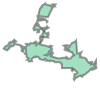

In [114]:
data_urban.geometry[3]

In [123]:
'''
Input: (float longitude, float latitude) tuple
Output: string name of urban area
'''
def lon_lat_to_urban_area(lon_lat):
    if lon_lat == 'NA':
        return 'NA'
    path_shp = './cb_2018_us_ua10_500k/cb_2018_us_ua10_500k.shp'
    data = gpd.read_file(path_shp)
    
    lon, lat = lon_lat
    point = Point(lon, lat)
    
    for ind in range(len(data)):
        polygon = data.geometry[ind]
        if point.within(polygon):
            return data.NAME10[ind]
r.extendWithFunction('lon_lat_parsed', lon_lat_to_urban_area, 'urban_area')

In [124]:
r.df.head()

,Entity ID,gov_building_subclass_P31,gov_building_subclass_P31Label,Country_P17,Country_P17Label,State_P131,State_P131Label,Lon_Lat_P625,building_type_label,lon_lat_parsed,fips,county_name,urban_area
0,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7624327,Strom Thurmond Federal Building and United Sta...,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q38453,Columbia,Point(-80.9384 34.0163),courthouse,"(-80.9384, 34.0163)",45079,Richland,"Columbia, SC"
1,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891079,United States Post Office and Court House,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q49241,Lexington,Point(-84.492222 38.046944),courthouse,"(-84.492222, 38.046944)",21067,Fayette,"Lexington-Fayette, KY"
2,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7103257,Orleans County Courthouse Historic District,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1384,New York,Point(-78.193333 43.245833),courthouse,"(-78.193333, 43.245833)",36073,Orleans,"Albion, NY"
3,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7891101,United States Post Office and Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q829,Utah,Point(-111.973056 41.223056),courthouse,"(-111.973056, 41.223056)",49057,Weber,"Ogden--Layton, UT"
4,http://www.wikidata.org/entity/Q1137809,http://www.wikidata.org/entity/Q7679018,Talbot County District Courthouse,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q1391,Maryland,Point(-76.0792 38.7742),courthouse,"(-76.0792, 38.7742)",24041,Talbot,"Easton, MD"
